In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.animation import FuncAnimation

import os
import glob
import pandas as pd
import json
from dotenv import load_dotenv
from functools import partial

from db_tools import get_db, classify_trajectories, metrics_grid, plot_grid, get_data

In [2]:
model = "bruss"
run_id = "blowup_test"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
output_dir = os.path.join(output_dir, model, run_id)
os.makedirs(output_dir, exist_ok=True)
df0 = get_db(os.path.join(data_dir, model, run_id))
df0['run_id'].unique()

array(['blowup_test'], dtype=object)

In [3]:
df = df0.copy()
df = df[df['run_id'] == run_id]
df_fine = df[df.dt == 0.0001]
df_fine

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic_u,sigma_ic_v,random_seed,n_snapshots,filename,run_id,num_sources
0,bruss,11.0,55.0,128,1.0,10000,0.0001,1.0,18.0,0.1,0.1,4,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
1,bruss,11.0,55.0,128,1.0,10000,0.0001,1.0,18.0,0.1,0.1,1,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
6,bruss,11.0,55.0,128,1.0,10000,0.0001,1.0,18.0,0.1,0.1,5,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
7,bruss,11.0,55.0,128,1.0,10000,0.0001,1.0,18.0,0.1,0.1,3,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
9,bruss,11.0,55.0,128,1.0,10000,0.0001,1.0,18.0,0.1,0.1,2,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0


In [4]:
df.loc[0, "filename"]

'/cluster/scratch/vogtva/data/bruss/blowup_test/c1aa62ef-8435-4ee7-ab75-77463eb163af_output.nc'

In [4]:
df_coarse = df[df.dt == 0.0025]
df_coarse

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic_u,sigma_ic_v,random_seed,n_snapshots,filename,run_id,num_sources
2,bruss,11.0,55.0,128,1.0,5000,0.0025,1.0,18.0,0.1,0.1,3,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
3,bruss,11.0,55.0,128,1.0,5000,0.0025,1.0,18.0,0.1,0.1,5,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
4,bruss,11.0,55.0,128,1.0,5000,0.0025,1.0,18.0,0.1,0.1,2,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
5,bruss,11.0,55.0,128,1.0,5000,0.0025,1.0,18.0,0.1,0.1,4,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0
8,bruss,11.0,55.0,128,1.0,5000,0.0025,1.0,18.0,0.1,0.1,1,500,/cluster/scratch/vogtva/data/bruss/blowup_test...,blowup_test,0


In [21]:
row = df_coarse.iloc[0]
print("T = ", row["dt"] * row["Nt"])
d = get_data(row)
# Check where values are NaN along the time axis
nan_mask = np.isnan(d)

# Get the last time index before NaNs (work with a reversed mask)
last_valid_idx = (~nan_mask).cumsum(axis=1).argmax(axis=1)

print(last_valid_idx.min(), last_valid_idx.max())

T =  12.5
13 24


In [ ]:
# Du = 1
# Dv = 4
# A = 5
# B = 12.5
row = df_fine.iloc[0]
ds = nc.Dataset(row["filename"])
data = ds.variables["data"][:]  # Assume shape [time, spatial, ...]
steady_state = np.zeros_like(data[0, 0, :, :])
steady_state[:, 0::2] = row["A"]
steady_state[:, 1::2] = row["B"] / row["A"]
Nt = data.shape[1]
deviations = []
time_derivatives = []
deviations_mean = []
du_dt = np.gradient(data[0, :, :, 0::2], row["dt"], axis=0)  # Time derivative of u
print(row["dt"])
for j in range(Nt - 50, Nt):
    u = data[0, j, :, :]
    du = steady_state[:, :] - u
    # print("min ", du.mean())
    # print("mean ", du.mean())
    # print("max ", du.max())
    # print("std ", du.std())
    deviations.append(np.linalg.norm(data[0, j, :, :] - steady_state))
    deviations_mean.append((data[0, j, :, :] - steady_state).mean())
    time_derivatives.append(np.linalg.norm(du_dt[j]))

u = data[0, :, :, 0::2]
v = data[0, :, :, 1::2]
time_derivatives

In [ ]:
df_class = classify_trajectories(df, 50, steady_threshold=1, osc_threshold=1, dev_threshold=1)

Du = 1
Dv = 18
df_filt = df[(df["Du"] == Du) & (df["Dv"] == Dv)]

for A in sorted(df_class['A'].unique()):
    for B_mult in [3, 3.5, 4, 4.5, 5, 5.5]:
        B=A*B_mult
        cat = df_class[(df_class['A'] == A) & (df_class['B'] == B)].iloc[0]['category']
        s = ""
        if cat == "steady_state":
            s = "SS"
        elif cat == "interesting_behavior":
            s = "I"
        else:
            s = "DU"
        print(f"{s:3}", end=" ")
    print("")

In [ ]:
plot_grid(df, 0, filename="blowup_1.png")

A :  3  values,  B :  6  values


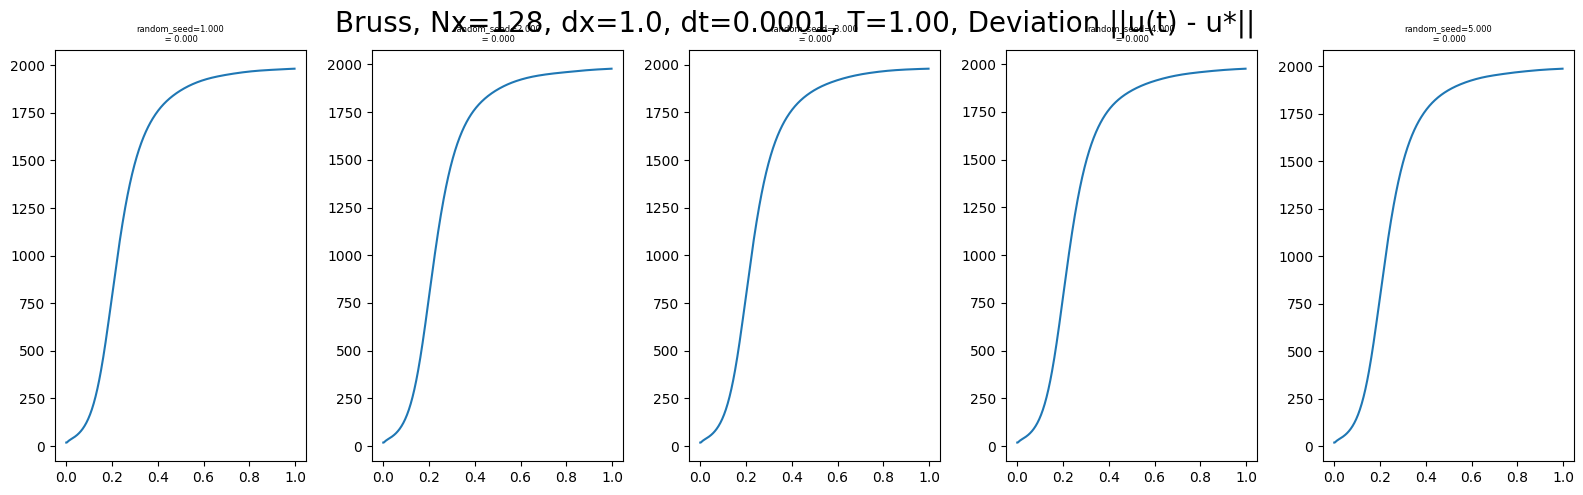

In [23]:
metrics_grid(df_fine, 0, var1="random_seed", var2="", metric="dev");

In [ ]:
Du = 1
Dv = 18
A = 11
B = 55
df_filt = df[(df["Du"] == Du) & (df["Dv"] == Dv) & (df["A"] == A) & (df["B"] == B)]

# row = df[(df["Du"] == Du) & (df["Dv"] == Dv) & (df["A"] == A) & (df["B"] == B)].iloc[0]
# ds = nc.Dataset(row["filename"])
# data = data = ds.variables["data"][:]
# for i in range(20):
#     print(np.max(data[0, i, :, 1::2]))

In [ ]:
for i, row in df_filt.iterrows():
    ds = nc.Dataset(row["filename"])
    data = data = ds.variables["data"][:]
    for i in range(15):
        print(np.max(data[0, i, :, 1::2]), sep=', ')

5.436693
5.3223476
5.5026
5.738907
6.077255
6.469717
6.675463
6.924285
7.3154707
7.6083484
7.675625
20.40521
32.460545
2288979.0
nan
5.361232
5.2949467
5.4563665
5.6771903
6.0143056
6.363746
6.623937
6.9992127
7.4668803
7.481801
7.419999
7.485446
33.10816
154507540000.0
nan
5.4133363
5.3122544
5.481375
5.735246
6.0850286
6.4708447
6.8621306
7.2668
7.2048016
7.3907976
7.449393
32.153458
33.229107
40.810406
34.61547
5.421632
5.3352485
5.5261645
5.77314
6.087223
6.3576694
6.7398243
6.9492846
7.3470826
7.46324
7.384156
7.421293
nan
nan
nan
5.416812
5.2839046
5.4437118
5.686216
6.033211
6.4143333
6.6602798
7.012426
7.1923156
7.4166527
7.416916
7.468519
22327.95
nan
nan


In [ ]:
df_class.category.value_counts()

category
interesting_behavior    226
steady_state            148
divergent_or_unknown      4
Name: count, dtype: int64

In [ ]:
from collections import defaultdict

Du_values = [1.0, 2.0, 3.0]
D_mult_values = [4, 11, 18]
A_values = [0.1, 0.5, 1, 2, 5, 10]
B_mult_values = [1.25, 1.75, 2, 2.5, 3, 4, 5]

# Initialize dictionaries to store distributions for each parameter
category_distribution = {
    "A": defaultdict(lambda: {"steady_state": 0, "interesting_behavior": 0, "divergent_or_unknown": 0}),
    "B_mult": defaultdict(lambda: {"steady_state": 0, "interesting_behavior": 0, "divergent_or_unknown": 0}),
    "Du": defaultdict(lambda: {"steady_state": 0, "interesting_behavior": 0, "divergent_or_unknown": 0}),
    "D_mult": defaultdict(lambda: {"steady_state": 0, "interesting_behavior": 0, "divergent_or_unknown": 0}),
}

# Iterate over all parameter combinations
for Du in Du_values:
    for D_mult in D_mult_values:
        Dv = Du * D_mult
        df_filt = df[(df["Du"] == Du) & (df["Dv"] == Dv)]

        # Update category distributions
        for A in sorted(A_values):
            for B_mult in B_mult_values:
                B = A * B_mult
                row = df_class[(df_class["A"] == A) & (df_class["B"] == B)]
                if not row.empty:
                    cat = row.iloc[0]["category"]
                    if cat == "steady_state":
                        category_distribution["A"][A]["steady_state"] += 1
                        category_distribution["B_mult"][B_mult]["steady_state"] += 1
                        category_distribution["Du"][Du]["steady_state"] += 1
                        category_distribution["D_mult"][D_mult]["steady_state"] += 1
                    elif cat == "interesting_behavior":
                        category_distribution["A"][A]["interesting_behavior"] += 1
                        category_distribution["B_mult"][B_mult]["interesting_behavior"] += 1
                        category_distribution["Du"][Du]["interesting_behavior"] += 1
                        category_distribution["D_mult"][D_mult]["interesting_behavior"] += 1
                    else:
                        category_distribution["A"][A]["divergent_or_unknown"] += 1
                        category_distribution["B_mult"][B_mult]["divergent_or_unknown"] += 1
                        category_distribution["Du"][Du]["divergent_or_unknown"] += 1
                        category_distribution["D_mult"][D_mult]["divergent_or_unknown"] += 1

# Print distributions for each parameter
def print_distributions(param_name, distribution):
    print(f"Distributions for {param_name}:")
    for param_value, counts in sorted(distribution.items()):
        total = sum(counts.values())
        print(f"  {param_value}: {counts} (total={total})")
    print("")

print_distributions("A", category_distribution["A"])
print_distributions("B_mult", category_distribution["B_mult"])
print_distributions("Du", category_distribution["Du"])
print_distributions("D_mult", category_distribution["D_mult"])


Distributions for A:
  0.1: {'steady_state': 63, 'interesting_behavior': 0, 'divergent_or_unknown': 0} (total=63)
  0.5: {'steady_state': 27, 'interesting_behavior': 36, 'divergent_or_unknown': 0} (total=63)
  1: {'steady_state': 9, 'interesting_behavior': 54, 'divergent_or_unknown': 0} (total=63)
  2: {'steady_state': 9, 'interesting_behavior': 54, 'divergent_or_unknown': 0} (total=63)
  5: {'steady_state': 9, 'interesting_behavior': 54, 'divergent_or_unknown': 0} (total=63)
  10: {'steady_state': 36, 'interesting_behavior': 18, 'divergent_or_unknown': 9} (total=63)

Distributions for B_mult:
  1.25: {'steady_state': 45, 'interesting_behavior': 9, 'divergent_or_unknown': 0} (total=54)
  1.75: {'steady_state': 36, 'interesting_behavior': 18, 'divergent_or_unknown': 0} (total=54)
  2: {'steady_state': 27, 'interesting_behavior': 27, 'divergent_or_unknown': 0} (total=54)
  2.5: {'steady_state': 9, 'interesting_behavior': 45, 'divergent_or_unknown': 0} (total=54)
  3: {'steady_state': 18,